### Проект: вариант 1
### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

import requests
from urllib.parse import urlencode

import scipy.stats as ss
import pingouin as pg
from scipy.stats import norm
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [3]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (10, 6)}
)
# настройки графиков по умолчанию

In [4]:
# Создаем ссылки на файл
users_ABtest_url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [5]:
# Создаем функцию для запроса к Яндексу:
def download_yandex(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [6]:
# Загружаем данные
users_ABtest = pd.read_csv(download_yandex(users_ABtest_url), sep=';')

In [7]:
# Проверяем пропущенные значения
users_ABtest.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [8]:
# Сбрасываем дубликаты
users_ABtest = users_ABtest.drop_duplicates()

#### Можно воспользоваться функцией describe для каждой группы и платящих пользователей, но консолидируем все основные показатели в одной таблице

In [9]:
main_indic = users_ABtest.groupby('testgroup', as_index=False) \
    .agg({'user_id': 'count', 'revenue': 'sum'}) \
    .rename(columns={'user_id': 'all_users'})

In [10]:
main_indic['paid_users'] = users_ABtest.query('revenue>0') \
                                       .groupby('testgroup', as_index=False) \
                                       .agg({'user_id': 'count'}).user_id
main_indic['ARPU'] = (main_indic.revenue / main_indic.all_users).round(2)
main_indic['ARPPU'] = (main_indic.revenue / main_indic.paid_users).round(2)
main_indic['CR'] = (main_indic.paid_users / main_indic.all_users * 100).round(2)
main_indic['min_revenue'] = users_ABtest.query('revenue>0') \
                                        .groupby('testgroup', as_index=False) \
                                        .agg({'revenue': 'min'}).revenue
main_indic['max_revenue'] = users_ABtest.query('revenue>0') \
                                        .groupby('testgroup', as_index=False) \
                                        .agg({'revenue': 'max'}).revenue
main_indic['median_revenue'] = users_ABtest.query('revenue>0') \
                                           .groupby('testgroup', as_index=False) \
                                           .agg({'revenue': 'median'}).revenue
main_indic['std'] = users_ABtest.query('revenue>0').groupby('testgroup', as_index=False).agg({'revenue': 'std'}).revenue
main_indic

,testgroup,all_users,revenue,paid_users,ARPU,ARPPU,CR,min_revenue,max_revenue,median_revenue,std
0,a,202103,5136189,1928,25.41,2664.00,0.95,200,37433,311,9049.039763
1,b,202667,5421603,1805,26.75,3003.66,0.89,2000,4000,3022,572.619709


In [17]:
# Рассчитаем, на сколько выручка в тестовой группе превышает выручку в контрольной группе
users_ABtest.query('testgroup=="b" & revenue>0') \
            .revenue.sum() / users_ABtest.query('testgroup=="a" & revenue>0') \
                                         .revenue.sum()

1.055569216786999

In [18]:
# Рассчитаем, на сколько ARPU в тестовой группе превышает ARPU в контрольной группе
main_indic.query('testgroup=="b"').reset_index().ARPU / main_indic.query('testgroup=="a"').reset_index().ARPU

0    1.052735
Name: ARPU, dtype: float64

In [19]:
# Рассчитаем, на сколько ARPPU в тестовой группе ARPPU выручку в контрольной группе
main_indic.query('testgroup=="b"').reset_index().ARPPU / main_indic.query('testgroup=="a"').reset_index().ARPPU

0    1.1275
Name: ARPPU, dtype: float64

In [20]:
# Рассчитаем, на сколько CR в контрольной группе превышает CR в  тестовой группе
main_indic.query('testgroup=="a"').reset_index().CR / main_indic.query('testgroup=="b"').reset_index().CR

0    1.067416
Name: CR, dtype: float64

#### Как видим, выручка в тестовой группе превышает выручку в контрольной группе на 5,5 %. Показатели ARPU и ARPPU также выше у тестовой группы на 5,2% и 12,8% соответственно. При этом CR выже у контрольной группы на 6,7%.

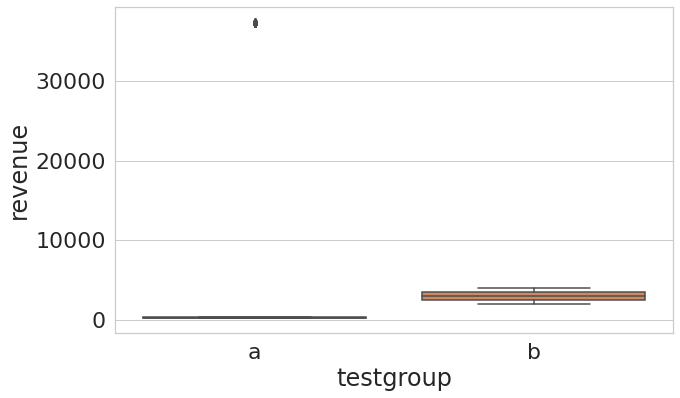

In [24]:
# Можно заметить в таблице, что в контрольной группе есть выбросы. Построим боксплот для контрольной и тестовой группы
sns.boxplot(x="testgroup", y="revenue", data=users_ABtest.query('revenue>0'))

In [25]:
# Посчитаем количество ползователей в контрольной группе, совершивших покупку более 30000
users_ABtest.query('testgroup=="a" & revenue>30000').revenue.count()

123

In [21]:
# Посчитаем долю пользователей в контрольной группе, совершивших покупку более 3000, 
# от общего числа ползователей в контрольной группе, совершивших покупку
users_ABtest.query('testgroup=="a" & revenue>3000') \
            .revenue.count() / users_ABtest.query('testgroup=="a" & revenue>0') \
                                           .revenue.count()

0.0637966804979253

#### Как видим, в контрольной группе присутствуют значительные выбросы : 123 пользователя совершили покупку свыше 30000 y.e, (макс. выручка = 37433 у.е.б мин. выручка = 200 у.е, медиана = 311 у.е.) . Данные выбросы и большая дисперсия, которые могут повлиять на результаты теста, могли быть вызваны неккореткным отбором или ошибкой пользователей во время сплитования. В то же время возможности проветси проверочный А/А тест нет, будем считать данные коррекнтыми с учетом выбросов.
#### В тестовой группе выбросы не наблюдаются, макс. выручка = 4000 у.е., мин.выручка = 2000 у.е., медиана = 3022 у.е
Оценим статистичкски значимые различия ARPU, ARPPU и CR в контрольной и тестовой группах. Для этого проверим данные в группах на нормальность распределения, гомогенность данных и определим, каким методом тестировать

### 2. Сравним ARPU в контрольной и тестовой группах

Нулевая гипотеза (H0) -  ARPU в контрольной и тестовой группах не различаются.

Альтернативная гипотеза (Н1) - ARPU в контрольной и тестовой группах различаются.

Проверим данные в группах на нормальность распределения - это требование к нормальности данных обеих групп при применении t-теста.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


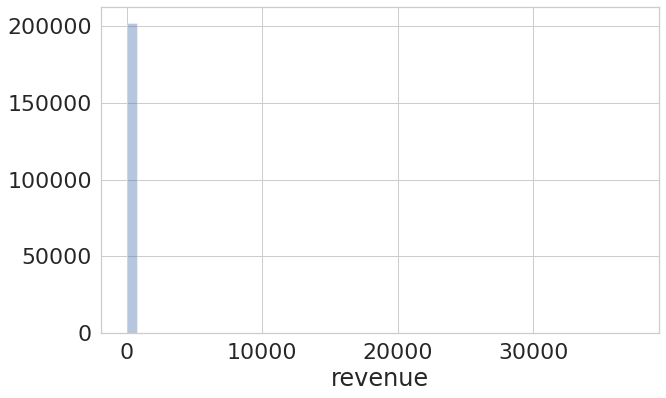

In [27]:
# Посмотрим на распределение контрольной группы
sns.distplot(users_ABtest.query('testgroup=="a"').revenue, kde=False)

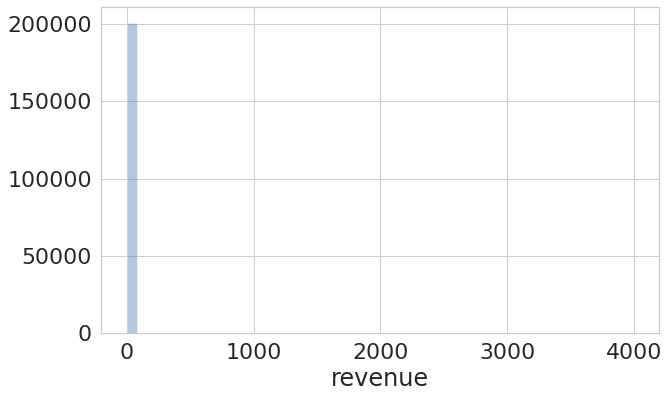

In [28]:
# Посмотрим на распределение тестовой группы
sns.distplot(users_ABtest.query('testgroup=="b"').revenue, kde=False)

In [23]:
# Протестируем нормальность распределения

print(ss.normaltest(users_ABtest.query('testgroup=="a"').revenue))
print(ss.normaltest(users_ABtest.query('testgroup=="b"').revenue))

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


#### Как видим из из графиков и по результатам теста распределение у групп ненормальное (скошено влево). Логарифмировать, чтобы сделать распределение более симметричным, не получится, так как в данных есть "0". 
#### На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов. При этом дисперсии внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий).

Тестируем различие в дисперсиях с помощью критерия Левена:

In [24]:
# через scipy
ss.levene(users_ABtest.query('testgroup=="a"').revenue, users_ABtest.query('testgroup=="b"').revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

In [25]:
# через pingouin
pg.homoscedasticity(data=users_ABtest, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


#### p-value > 0.05, дисперсии являются одинаковыми (гомогенны), поэтому можем применить Т-критерий Стьюдента 

In [27]:
ttest_ind(users_ABtest.query('testgroup=="a"').revenue,
          users_ABtest.query('testgroup=="b"').revenue)
# Проводим t-test (тест Стюдента) дла revenue

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

#### P-value > 0.05, поэтому верна нулевая гипотеза отравенстве ARPU  в группах, статистчески значимых различий в выборках нет.

При этом Т-критерий Стьюдента чуствителен к выбросам.
Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в ранговую шкалу (ранжирует показатели температуры от 1 до последнего), после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов. Попробуем сравнить ARPU с его помощью: 

In [26]:
mannwhitneyu(users_ABtest.query('testgroup=="a"').revenue,
             users_ABtest.query('testgroup=="b"').revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

С помощью U-критерий Манна-Уитни в данном случае мы получили p=0.06, что тоже поставило под вопрос отклонение нулевой гипотезы о равенстве ARPU, но это явно лучше, чем p=0.53.

###  3. Сравним ARPPU в контрольной и тестовой группах

Нулевая гипотеза (H0) -  ARPPU в контрольной и тестовой группах не различаются.

Альтернативная гипотеза (Н1) - ARPPU в контрольной и тестовой группах различаются.

Проверим данные в группах на нормальность распределения - это требование к нормальности данных обеих групп при применении t-теста.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


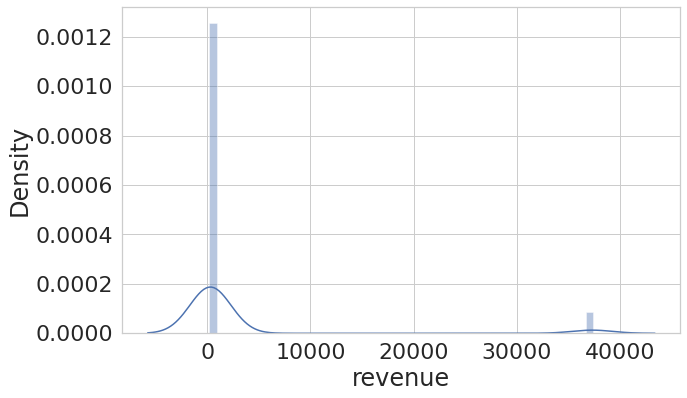

In [30]:
# Посмотрим на распределение контрольной группы
sns.distplot(users_ABtest.query('testgroup=="a" & revenue>0').revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


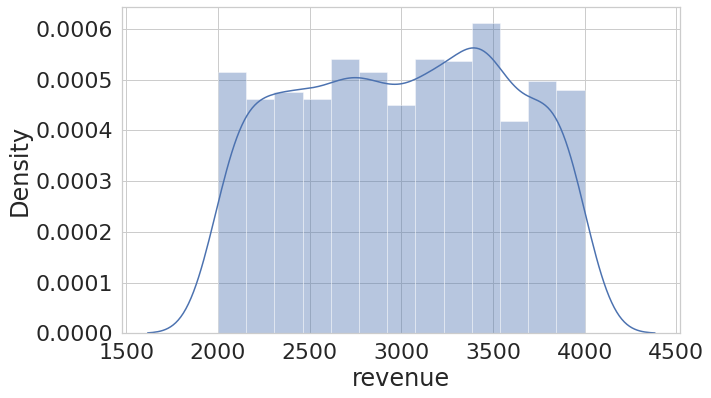

In [31]:
# Посмотрим на распределение тестовой группы
sns.distplot(users_ABtest.query('testgroup=="b" & revenue>0').revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


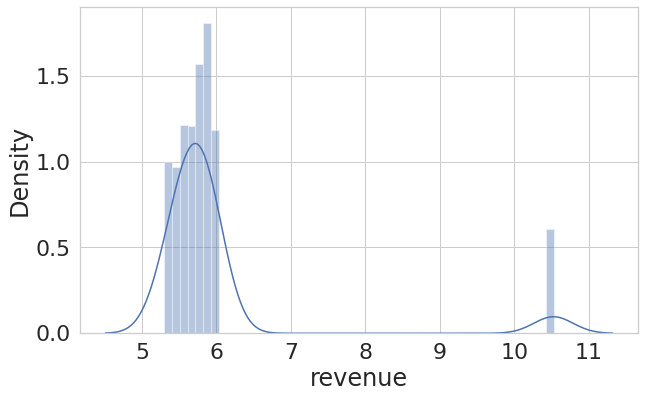

In [32]:
# С помощью логарифма  попробуем привести к нормальному распределению
sns.distplot(np.log(users_ABtest.query('testgroup=="a" & revenue>0').revenue))

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


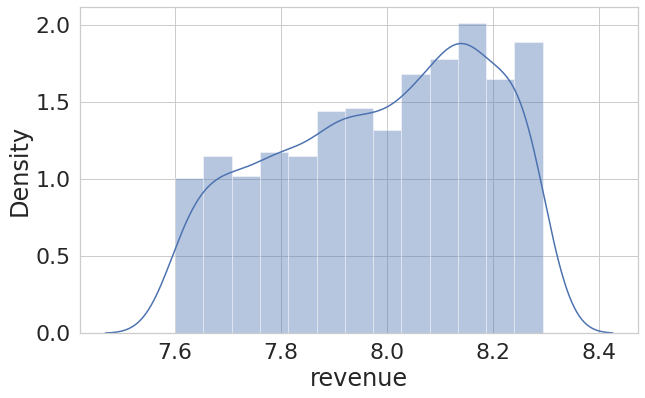

In [33]:
sns.distplot(np.log(users_ABtest.query('testgroup=="b" & revenue>0').revenue))

In [28]:
# Протестируем нормальность распределения

print(ss.normaltest(users_ABtest.query('testgroup=="a" & revenue>0').revenue))
print(ss.normaltest(users_ABtest.query('testgroup=="b" & revenue>0').revenue))

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)
NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)


#### Как видим из из графиков и по результатам теста распределение у групп также ненормальное. Логарифмирование не помогло сделать распределение более симметричным

Тестируем различие в дисперсиях с помощью критерия Левена:

In [30]:
# через scipy
ss.levene(users_ABtest.query('testgroup=="a" & revenue>0').revenue, 
          users_ABtest.query('testgroup=="b" & revenue>0').revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

 #### Дисперсии не являются одинаковыми (не гомогенны), Т-критерий Стьюдента применить не можем. Воспользуемся методом bootstrap.
 Бутстрап — целое семейство методов, позволяющих проверять гипотезы с помощью повторных выборок. Бутстрап проверяет статистические гипотезы без опоры на определённое теоретическое распределение данных (в отличие от классических статистических критериев).

In [49]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [31]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [32]:
control = users_ABtest.query('testgroup=="a" & revenue>0').revenue.reset_index(drop=True)
test = users_ABtest.query('testgroup=="b" & revenue>0').revenue.reset_index(drop=True)

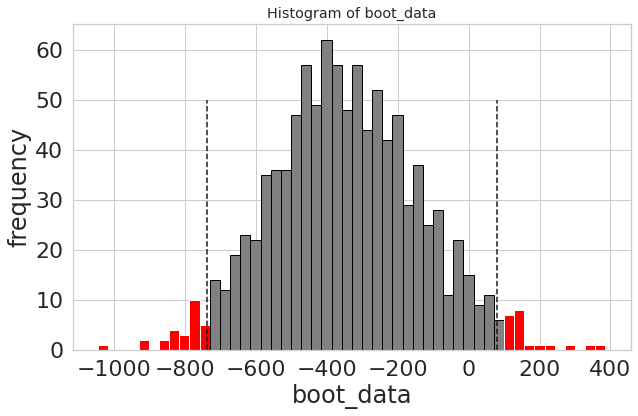

In [33]:
booted_data = get_bootstrap(control, test)  # в результате хранится разница двух распределений, ДИ и pvalue

In [34]:
booted_data["p_value"]  # альфа

0.09601095843846995

In [35]:
booted_data["quants"]  # ДИ

,0
0.025,-739.844826
0.975,79.053994


#### По результатам бустрапа P-value > 0.05, '0' входит в доверительный интревал, поэтому не можем отклонить нулевую гипотезу о равенстве ARPPU контрольной и тестовой групп

### 4. Сравним конверсии в покупу (CR) в контрольной и тестовой группах

Нулевая гипотеза (H0) -  CR в контрольной и тестовой группах не различаются.

Альтернативная гипотеза (Н1) - CR в контрольной и тестовой группах различаются.

Для сравнения CR межде тестовой и контрольной группами использумем Критерий Хи-квадрат для двух случайных величин.

In [36]:
CR_data = users_ABtest.query('revenue>0') \
                      .groupby('testgroup') \
                      .agg({'revenue': 'count'}) \
                      .rename(columns={'revenue': 'paid_users'}) \
                      .reset_index()
CR_data

,testgroup,paid_users
0,a,1928
1,b,1805


In [37]:
CR_data['nopaid_users'] = users_ABtest.query('revenue==0') \
                                      .groupby('testgroup') \
                                      .agg({'revenue': 'count'}) \
                                      .reset_index().revenue
CR_data

,testgroup,paid_users,nopaid_users
0,a,1928,200175
1,b,1805,200862


In [39]:
CR_data_pivot = CR_data.pivot_table(columns='testgroup', values=['paid_users', 'nopaid_users'])
CR_data_pivot

testgroup,a,b
nopaid_users,200175,200862
paid_users,1928,1805


In [40]:
stat, p, dof, expected = ss.chi2_contingency(CR_data_pivot)
print(p)

0.03647561892312613


#### p-value <0.05, нулевая гипотеза о равенстве CR отвергается, различия конверсии в покупку между контрольной и тестовой группами статистически значимы

### Вывод:


По результатам проведенного анализа трех выбранных метрик ARPU, ARPPU и CR (кноверсии в покупку) можно сделать вывод, что статистичкски значимых различий ARPU и ARPPU между контрольной и тестовой группами нет, хоть и значения ARPU и ARPPU в тестовой группе выше чем в контрольной. Значения CR наоборот показали статистически значимые различия, по которым можно сделать вывод о том, что конверсия в покупку в контрольной группе со старым набором акционных предложений выше чем конверсия в покупку в тестовой - в тестовой группе мы теряем платежеспособных клиентов. Однако стоит обратить внимание на выбросы и большую дисперсию в данных контрольной группы, которые могут оказать влиние на результаты выбора. В случае уменьшения пользователей , совершивших покупку свыше 30000 у.е. при сильной дисперсии могут сильно ухудшить показатели ARPU и ARPPU. В то время как в тестовой группе данные показатели, а также общая выручка,  выше чем в контрольной. Поэтому тестовая группа с новым набором акционных предложений может выглядеть привлекательнее.

Поэтому лучше сперва провести дополнительный А/А-тест на проверку правильности формирования пользоватетей в группах, а затем снова провести А/Б-тест.